In [2]:
import pandas as pd
import regex as re
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from skmisc.loess import loess
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Read In Data

In [3]:
# Reading In csv's, making sure there are no duplicates, and dropping rows without a previous year's salary

target_hist = pd.read_csv('2018_Free_Agents_For_Prediction.csv', index_col=0)
hist = pd.read_csv('new_historical_df.csv', index_col=0)
hist = hist.drop_duplicates()
target_hist = target_hist.drop_duplicates()
hist = hist[hist['Previous Year Salary'].notnull()]

In [4]:
# Adding position dummies to dataframe

hist = pd.concat([hist, pd.get_dummies(hist['Position'])], axis=1)
target_hist = pd.concat([target_hist, pd.get_dummies(target_hist['Position'])], axis=1)

In [5]:
# Looking at correlations for the target (Percentage of the team's salary cap)

hist[hist.columns[0:]].corr()['Target Salary Percentage Cap'][:-1].sort_values()

index                                                -0.316369
Previous Year Bottom 6 Team                          -0.164892
Team Cap Space                                       -0.143476
ACL                                                  -0.110707
Previous Year Turnover Percentage                    -0.088601
Tears                                                -0.088468
Previous Year 3 Point Attempt Rate                   -0.084733
PG                                                   -0.073460
SF                                                   -0.065192
PG-SG                                                -0.060543
Tear Sum                                             -0.056370
Meniscus Sum                                         -0.056147
Meniscus/Achilles/ACL Sum                            -0.056145
Achilles                                             -0.042803
C-PF                                                 -0.022842
ACL Sum                                              -0

In [6]:
# Filling null values with 0. In this case the lack of data for a statistic can be interpreted as 0

hist = hist.fillna(0)
target_hist = target_hist.fillna(0)
target_hist = target_hist.drop_duplicates()

# Model Preperation

In [7]:
# Setting up X and y

X = hist[['Previous Year Win Shares',
          'Previous Year Field Goals Per Game',
          'Previous Year Offensive Win Shares',
          'Previous Year Value Over Replacement Player',
          'Age',
          'Previous Year Games Started',
          'Previous Year Games Played',
          'Maximum Salary',
          'Minimum Salary',
          'Years In League',
          'Previous Year Salary',
          'Salary Cap',
          'Previous Year Bottom 6 Team',
          'Meniscus/Achilles/ACL Sum',
          'Previous Year 2 Point Field Goal Percentage',
          'Total NBA Cap Space',
          'Previous Year Playoff Team',
          'Previous Year Free Throw Percentage',
          'Previous Year 3 Point Field Goals Per Game',
          'Previous Year Points Per Game',
          'Previous Year Assists Per Game',
          'Previous Year Player Efficiency Rating',
          'PF',
          'SF',
          'PG',
          'C',
          'Previous Year Blocks Per Game',
         ]]



y = hist['Target Salary Percentage Cap']

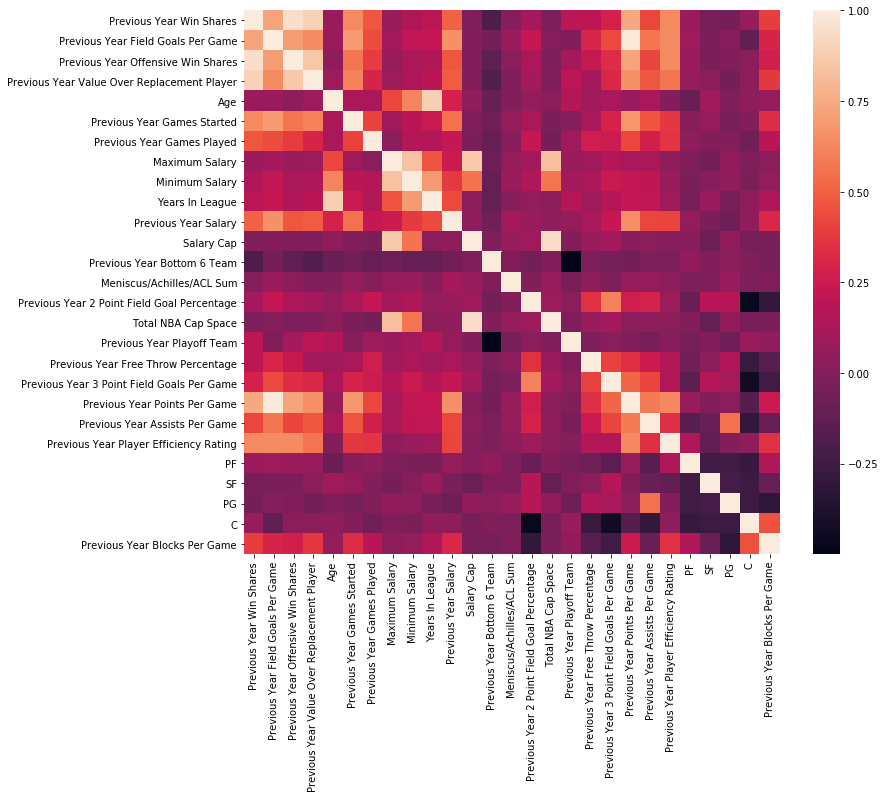

In [8]:
# Looking at correlations in a heatmap

fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(X.corr());

In [9]:
target_hist = target_hist.drop_duplicates(subset='Name With Year')

In [10]:
# Setting up X and y for 2018 predictions

target_X = target_hist[['Previous Year Win Shares',
          'Previous Year Field Goals Per Game',
          'Previous Year Offensive Win Shares',
          'Previous Year Value Over Replacement Player',
          'Age',
          'Previous Year Games Started',
          'Previous Year Games Played',
          'Maximum Salary',
          'Minimum Salary',
          'Years In League',
          'Previous Year Salary',
          'Salary Cap',
          'Previous Year Bottom 6 Team',
          'Meniscus/Achilles/ACL Sum',
          'Previous Year 2 Point Field Goal Percentage',
          'Total NBA Cap Space',
          'Previous Year Playoff Team',
          'Previous Year Free Throw Percentage',
          'Previous Year 3 Point Field Goals Per Game',
          'Previous Year Points Per Game',
          'Previous Year Assists Per Game',
          'Previous Year Player Efficiency Rating',
          'PF', 
          'SF',
          'PG',
          'C',      
          'Previous Year Blocks Per Game',
         ]]

target_y = target_hist['Target Salary Percentage Cap']

In [11]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Modeling

In [12]:
# Linear regression/scoring

lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Score: ', lr.score(X_train, y_train))
print('Test Score: ', lr.score(X_test, y_test))

predictions = lr.predict(X_test)
predictions2018 = lr.predict(target_X)
for i in range(0,len(predictions)):
    if predictions[i] < X_test['Minimum Salary'][i]/X_test['Salary Cap'][i]:
        predictions[i] = X_test['Minimum Salary'][i]/X_test['Salary Cap'][i]
    elif predictions[i] > X_test['Maximum Salary'][i]/X_test['Salary Cap'][i]:
        predictions[i] = X_test['Maximum Salary'][i]/X_test['Salary Cap'][i]
    else:
        continue
for i in range(0,len(predictions2018)):
    if predictions2018[i] < target_X['Minimum Salary'][i]/target_X['Salary Cap'][i]:
        predictions2018[i] = target_X['Minimum Salary'][i]/target_X['Salary Cap'][i]
    elif predictions2018[i] > target_X['Maximum Salary'][i]/target_X['Salary Cap'][i]:
        predictions2018[i] = target_X['Maximum Salary'][i]/target_X['Salary Cap'][i]
    else:
        continue
print(' ')
print('R2 Score: ', metrics.r2_score(y_test, predictions))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('Root Mean Squared Error In Dollars: ', hist['Salary Cap'].values.sum()/hist['Salary Cap'].value_counts().sum() * np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Train Score:  0.7294131190626849
Test Score:  0.7500917469383188
 
R2 Score:  0.7834998324767196
Root Mean Squared Error:  0.026709581838546513
Root Mean Squared Error In Dollars:  1888109.47370215


# Setting Up Predictions Dataframes

In [13]:
# Setting up predictions dataframe for test set and 2018

preds = pd.DataFrame(predictions, index=y_test.index)
target_preds = pd.DataFrame(predictions2018, index=target_y.index)

In [14]:
# Renaming column

preds.rename(columns={0:'Percent Predictions'}, inplace=True)
target_preds.rename(columns={0:'Percent Predictions'}, inplace=True)

In [15]:
# Converting prediction percentages to dollars

dollar_preds = preds['Percent Predictions'] * X_test['Salary Cap']
target_dollar_preds = target_preds['Percent Predictions'] * target_X['Salary Cap']

In [16]:
# Changing dollar predictions from scientific notation

pred_list = []
for i in range(0, len(dollar_preds)):
    real = format(dollar_preds[i], '.8f')
    pred_list.append(real)
    
target_pred_list = []
for i in range(0, len(target_dollar_preds)):
    real = format(target_dollar_preds.values[i], '.8f')
    target_pred_list.append(real)

In [17]:
# Setting up more columns for prediction dataframe

preds['Dollar Predictions'] = pred_list
preds['Actual Percentage'] = y_test
preds['Actual Dollar'] = y_test * X_test['Salary Cap']
preds['Percent Difference'] = preds['Percent Predictions'] - preds['Actual Percentage']

target_preds['Dollar Predictions'] = target_pred_list

In [18]:
# Converting dollar predictions from strings to floats

preds['Dollar Predictions'] = pd.to_numeric(preds['Dollar Predictions'])

In [19]:
# Calculating my error in dollars and adding to prediction dataframe

dollar_diff = []
for i in range(0, len(abs(X_test['Salary Cap'] * preds['Percent Difference']))):
    real = format(abs(X_test['Salary Cap'] * preds['Percent Difference'])[i], '.8f')  
    dollar_diff.append(real)
preds['Dollar Difference'] = dollar_diff
preds['Dollar Difference'] = pd.to_numeric(preds['Dollar Difference'])

In [20]:
preds['Outliers'] = abs(preds['Dollar Difference']) > 5000000

In [21]:
# Looking at prediction dataframe sorted by the percent difference

preds.sort_values('Percent Difference')

,Percent Predictions,Dollar Predictions,Actual Percentage,Actual Dollar,Percent Difference,Dollar Difference,Outliers
Join Name With Year,,,,,,,
2016 Goran Dragic,0.114238,7.996660e+06,0.211143,14780000.0,-9.690486e-02,6.783340e+06,True
2018 Serge Ibaka,0.131803,1.306075e+07,0.202454,20061729.0,-7.065056e-02,7.000976e+06,True
2018 Kentavious Caldwell-Pope,0.122522,1.214103e+07,0.179083,17745894.0,-5.656169e-02,5.604867e+06,True
2012 Kwame Brown,0.061657,3.578800e+06,0.116291,6750000.0,-5.463441e-02,3.171200e+06,False
2018 Taj Gibson,0.091723,9.089097e+06,0.141281,14000000.0,-4.955853e-02,4.910903e+06,False
2017 Arron Afflalo,0.087101,8.199914e+06,0.132777,12500000.0,-4.567611e-02,4.300086e+06,False
2015 Marvin Williams,0.067142,4.234321e+06,0.110997,7000000.0,-4.385442e-02,2.765679e+06,False
2011 Tyrus Thomas,0.072675,4.218355e+06,0.113906,6611570.0,-4.123106e-02,2.393215e+06,False
2015 Ben Gordon,0.031851,2.008670e+06,0.071355,4500000.0,-3.950417e-02,2.491330e+06,False


# Visualizing Predictions

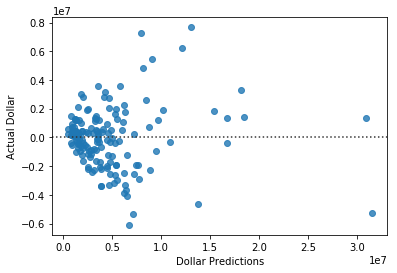

In [22]:
# Residual plot for dollar predictions

sns.residplot(preds['Dollar Predictions'], preds['Actual Dollar']);

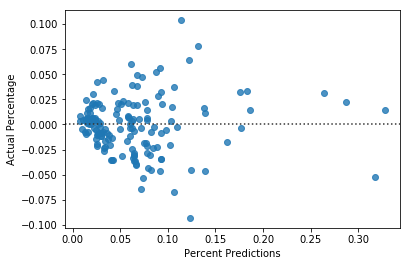

In [23]:
# Residual plot for percentage predictions

sns.residplot(preds['Percent Predictions'], preds['Actual Percentage']);

In [24]:
font = {'size'   : 13}

plt.rc('font', **font)

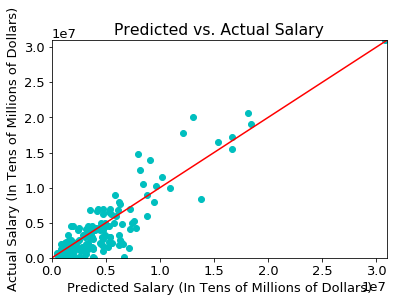

In [25]:
# Scatterplot for dollar predictions vs. actuals

line_start = preds['Actual Dollar'].min() 
line_end = preds['Actual Dollar'].max()

plt.figure()
plt.scatter(preds['Dollar Predictions'], preds['Actual Dollar'], c='c')
plt.plot([line_start, line_end], [line_start, line_end], 'k-', color = 'r')
plt.xlabel('Predicted Salary (In Tens of Millions of Dollars)')
plt.ylabel('Actual Salary (In Tens of Millions of Dollars)')
plt.title('Predicted vs. Actual Salary')
plt.xlim(line_start, line_end)
plt.ylim(line_start, line_end)
plt.show()

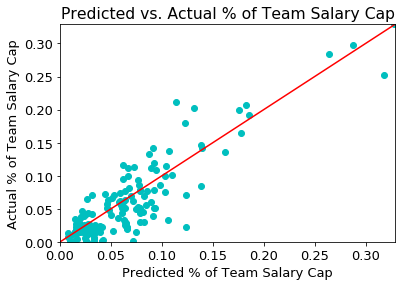

In [26]:
# Scatterplot for percent predictions vs. actuals

warnings.filterwarnings("ignore", category=UserWarning)
line_start = preds['Actual Percentage'].min() 
line_end = preds['Actual Percentage'].max()

plt.figure()
plt.scatter(preds['Percent Predictions'], preds['Actual Percentage'], c=('c'), label=preds['Outliers']);
plt.plot([line_start, line_end], [line_start, line_end], 'k-', color = 'r')
plt.title('Predicted vs. Actual % of Team Salary Cap')
plt.xlabel('Predicted % of Team Salary Cap')
plt.ylabel('Actual % of Team Salary Cap')
plt.xlim(line_start, line_end)
plt.ylim(line_start, line_end)
plt.show()


# Predictions For 2018 Free Agents

In [27]:
# Looking at 2018 predictions

target_preds

,Percent Predictions,Dollar Predictions
Join Name With Year,,
2019 Anthony Tolliver,0.080651,8215855.86243022
2019 Aron Baynes,0.077023,7846289.39145693
2019 Brook Lopez,0.156342,15926439.29737352
2019 Channing Frye,0.023500,2393887.00000000
2019 Dante Cunningham,0.028649,2918474.10316388
2019 DeAndre Jordan,0.204752,20857916.30191786
2019 DeMarcus Cousins,0.235422,23982197.37413560
2019 Derrick Rose,0.021258,2165481.00000000
2019 Doug McDermott,0.034228,3486757.25948273
